# 📘 Sentiment Analysis using RNN
**What you'll learn**:
- How text is preprocessed for RNN input (tokenization, vocab, encoding, padding).
- How embeddings represent words and why pretrained embeddings (GloVe) help.
- How an RNN  processes text step-by-step: embeddings → hidden states → pooling → classification.
- How to evaluate the model and perform simple error analysis.


In [1]:
# ==============================
# Step 1: Import libraries
# ==============================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from collections import Counter
import numpy as np
import re
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import torch.nn.functional as F


/Users/harshvivek/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 1) Dataset: IMDb (HuggingFace `datasets`)

We use the IMDb movie reviews dataset (50,000 reviews: 25k train / 25k test). Labels are `0` (negative) and `1` (positive). We'll load the dataset and show a few examples so you understand the raw text data we'll work with.

In [2]:
# Load dataset
from datasets import load_dataset

dataset = load_dataset('imdb')
train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

print(f"Train samples: {len(train_texts)}, Test samples: {len(test_texts)}\n")
print("--- Example train review (truncated) ---\n", train_texts[0][:500], "\n\nLabel:", train_labels[0])

Train samples: 25000, Test samples: 25000

--- Example train review (truncated) ---
 I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attent 

Label: 0


## 2) Text preprocessing: tokenization, vocabulary, encoding, padding

Why preprocessing is needed:
- Neural networks require numeric inputs. We convert raw text into sequences of integer IDs.
- Tokenization splits text into words. Vocabulary maps words to IDs.
- Padding ensures all sequences in a batch have the same length (required by most RNN implementations).



### Tokenization and Vocabulary Building

To feed text into an RNN, we need numbers, not raw words.  
This requires a pipeline:

1. **Tokenize**: split sentences into lowercase words.  
   - Example: `"I loved this movie!"` → `["i", "loved", "this", "movie"]`

2. **Build Vocabulary**: assign each unique word a unique ID.  
   - Example: `"movie"` → 542, `"love"` → 134

3. **Encoding**: convert words → IDs for each review.  
   - `"I love this movie"` → `[54, 120, 23, 542]`

4. **Padding**: fix length (e.g., 200 words).  
   - Too short? Pad with `<PAD>=0`.  
   - Too long? Truncate.



In [3]:
# Tokenization and vocabulary building
import re
from collections import Counter

# 1) Tokenizer: lowercases and extracts word tokens using regex.
#    \b\w+\b matches word tokens (letters/digits/underscore sequences).
def tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

# 2) Build frequency counter over training data
counter = Counter()
for text in train_texts:
    counter.update(tokenize(text))

# 3) Create a vocabulary mapping: most common words -> integers.
# Reserve two special tokens:
#  - 0: <PAD>  (used for padding shorter sequences)
#  - 1: <UNK>  (unknown/out-of-vocabulary words)

tokenized_train = [tokenize(t) for t in train_texts]
tokenized_test = [tokenize(t) for t in test_texts]
word_counts = Counter(word for tokens in tokenized_train for word in tokens)

vocab = {word: idx+2 for idx, (word, _) in enumerate(word_counts.items())}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

print('Vocabulary size (including PAD and UNK):', len(vocab))
print("Example mapping: 'movie' ->", vocab.get('movie'))

# 4) Encoding function: convert text -> fixed-length list of IDs.
def encode(text, vocab, max_len=200):
    tokens = tokenize(text)
# -  Map each token to its ID; if not present use <UNK>=1
    ids = [vocab.get(tok, 1) for tok in tokens]
    # Truncate long sequences, pad short ones with 0 (<PAD>)
    if len(ids) >= max_len:
        ids = ids[:max_len]
    else:
        ids = ids + [0] * (max_len - len(ids))
    return ids

# Quick check with a toy sentence
sent = "I love this movie so much! It's brilliant."
print('Tokens:', tokenize(sent))
print('Encoded (first 20 IDs):', encode(sent, vocab)[:20])

Vocabulary size (including PAD and UNK): 74893
Example mapping: 'movie' -> 379
Tokens: ['i', 'love', 'this', 'movie', 'so', 'much', 'it', 's', 'brilliant']
Encoded (first 20 IDs): [2, 618, 38, 379, 308, 180, 18, 31, 5611, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## 3) Word Embeddings: random init vs pretrained (GloVe)

Embeddings map integer word IDs to dense vectors (e.g., 100 dimensions). They capture semantic similarity: similar words have similar vectors.  
Two options:
- **Randomly initialized embeddings**: learned from scratch during training.
- **Pretrained embeddings (GloVe)**: trained on large corpora and can improve generalization, especially with limited labeled data.

Below we provide code to load GloVe and build an embedding matrix aligned with our vocabulary. Note: downloading GloVe may take time (~862MB for the full zip).

In [4]:
# ==============================
# Download GloVe embeddings (6B tokens, 100d vectors)
# ==============================
import os
import zipfile
import requests
from tqdm import tqdm

# URL and file paths
url = "http://nlp.stanford.edu/data/glove.6B.zip"
zip_path = "glove.6B.zip"
glove_file = "glove.6B.100d.txt"

# Download if not already present
if not os.path.exists(glove_file):
    if not os.path.exists(zip_path):
        print("Downloading GloVe embeddings (862MB)...")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        with open(zip_path, "wb") as f, tqdm(
            desc=zip_path, total=total_size, unit='B', unit_scale=True, unit_divisor=1024
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = f.write(data)
                bar.update(size)

    # Unzip only glove.6B.100d.txt
    print("Extracting GloVe embeddings...")
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extract(glove_file)

print(f"GloVe embeddings ready: {glove_file}")

# Function to load GloVe and create embedding matrix
def load_glove_embeddings(filepath, vocab, embed_dim=100):
    embeddings_index = {}
    with open(filepath, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = vector

    embedding_matrix = np.zeros((len(vocab), embed_dim))
    for word, idx in vocab.items():
        if word in embeddings_index:
            embedding_matrix[idx] = embeddings_index[word]
        else:
            # assign random vector for words not found in GloVe
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embed_dim,))
    return embedding_matrix

# Create the embedding matrix
embed_dim = 100
glove_path = "glove.6B.100d.txt"   # make sure you downloaded it earlier
embedding_matrix = load_glove_embeddings(glove_path, vocab, embed_dim)

print("Embedding matrix shape:", embedding_matrix.shape)



GloVe embeddings ready: glove.6B.100d.txt
Embedding matrix shape: (74893, 100)


## 4) PyTorch Dataset & DataLoader - batching and tensors

We convert encoded sequences into PyTorch tensors and create a `Dataset` class so `DataLoader` can batch and shuffle the data efficiently. Batching is essential for performance and stable gradient estimates.

In [5]:
# Convert encoded sequences to tensors and build DataLoader
import torch
from torch.utils.data import Dataset, DataLoader

# Encode all reviews (this can take some time)
MAX_LEN = 200
X_train = [encode(t, vocab, max_len=MAX_LEN) for t in train_texts]
X_test  = [encode(t, vocab, max_len=MAX_LEN) for t in test_texts]

class IMDbDataset(Dataset):
    def __init__(self, X, y):
        # store as LongTensors because embedding layers expect Long indices
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets and dataloaders
BATCH_SIZE = 128
train_dataset = IMDbDataset(X_train, train_labels)
test_dataset = IMDbDataset(X_test, test_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print('Train batches:', len(train_loader), 'Test batches:', len(test_loader))

Train batches: 196 Test batches: 196


## 5) Model: RNN Classifier 

### Architecture
1. **Embedding layer**: converts word IDs to dense vectors (shape: `embed_dim`).
2. **RNN (Recurrent Neural Network)**: processes the sequence of word vectors and captures information from previous time steps.
3. **Pooling (max)**: takes the maximum value of the hidden states across the time dimension to get a single fixed-size sentence representation.
4. **Linear layer**: performs the final classification based on the pooled representation.

---

### Why max pooling?
- We have one hidden vector per word (`seq_len` of them).
- For classification, we need a single fixed-size vector per review.
- Max pooling picks the **strongest activation** for each hidden dimension across the whole sequence.

---

### Intuition
Think of max pooling as a **sentiment detector** scanning through the review:

- Each hidden dimension acts like a "feature detector" (e.g., positive tone, negation, sarcasm, etc.).
- Max pooling asks: *“Across the whole review, what was the strongest evidence I saw for each feature?”*
- That way, even if the important word appears only once, it still strongly influences the final representation.

---

### Advantages
- **Compared to last hidden state** → avoids losing information if the last word is unimportant.  
- **Compared to mean pooling** → avoids diluting strong signals with weaker ones.  

Result: a robust summary vector that highlights the most important signals.

---

### Example: Max pooling step
Hidden states for 1 review (`seq_len=4`, `hidden_dim=3`):

word1 → [0.1, -0.3,  0.7]  
word2 → [0.5, -0.1, -0.2]  
word3 → [0.2,  0.4,  0.6]  
word4 → [0.9, -0.2,  0.1]  

Max pooling → [ max(0.1,0.5,0.2,0.9), max(-0.3,-0.1,0.4,-0.2), max(0.7,-0.2,0.6,0.1) ]  
            → [0.9, 0.4, 0.7]


Result: a single vector [0.9, 0.4, 0.7] that summarizes the whole sequence.

In [6]:
# ==============================
# RNN Classifier with GloVe
# ==============================
class RNNClassifier(nn.Module):   
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, embeddings=None, freeze=True, num_layers=2, dropout=0.5):
        super(RNNClassifier, self).__init__()   # Call the parent constructor

        # ---------------------------
        # 1) Embedding Layer
        # ---------------------------
        # Converts integer word IDs into dense vectors of size embed_dim
        # vocab_size = number of unique words in our vocabulary
        # padding_idx=0 ensures that the <PAD> token always maps to a zero vector
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # If pretrained embeddings (e.g., GloVe) are provided, copy them into the embedding layer
        if embeddings is not None:
            self.embedding.weight.data.copy_(torch.tensor(embeddings))
            # If freeze=True → embeddings are frozen (not updated during training)
            # If freeze=False → embeddings are fine-tuned with backprop
            self.embedding.weight.requires_grad = not freeze  

        # ---------------------------
        # 2) RNN Layer
        # ---------------------------
        # A standard RNN processes sequences step by step:
        #   input: (batch_size, seq_len, embed_dim)
        #   output: (batch_size, seq_len, hidden_dim)
        #   hidden: (num_layers, batch_size, hidden_dim)
        # Arguments:
        # - embed_dim: size of word embeddings
        # - hidden_dim: size of hidden state
        # - batch_first=True → batch dimension comes first (batch, seq_len, feature)
        # - num_layers: allows stacking multiple RNN layers
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True, dropout=dropout, num_layers=num_layers)

        # ---------------------------
        # 3) Fully Connected (FC) Layer
        # ---------------------------
        # Maps from hidden_dim → num_classes (binary sentiment: 2 classes)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: (batch_size, seq_len), containing word IDs
        x = self.embedding(x)   # → (batch_size, seq_len, embed_dim)

        # Pass through RNN
        # out: hidden states for each time step → (batch_size, seq_len, hidden_dim)
        # hidden: final hidden state of the last layer → (num_layers, batch_size, hidden_dim)
        out, hidden = self.rnn(x)

        # Pooling step: take the maximum activation across the time dimension
        # Idea: capture the most important signal across all words in the sequence
        # Result: (batch_size, hidden_dim)
        out, _ = torch.max(out, dim=1)

        # Fully connected layer maps pooled features → logits for each class
        # logits: (batch_size, num_classes)
        logits = self.fc(out)

        return logits


## 6) Training loop — what happens at each step (deep explained)

For each batch:
1.  **Zero gradients**: clear previous gradient values (`optimizer.zero_grad()`).
2.  **Forward pass**: compute logits from the model given the input batch.
3.  **Loss calculation**: compute classification loss (CrossEntropyLoss combines LogSoftmax + NLLLoss).
4.  **Backward pass (BPTT)**: `loss.backward()` computes gradients for every parameter, propagating errors back through time steps in the RNN.
5.  **Optimizer step**: `optimizer.step()` updates parameters using gradients.

We'll also keep track of training loss and validation accuracy for each epoch.

In [7]:
"""## 6) Training loop"""

def train_model(model, train_loader, test_loader, epochs=15, lr=0.001):
    # Select device (GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Loss function: CrossEntropy (for classification)
    criterion = nn.CrossEntropyLoss()
    # Optimizer: Adam
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_accuracies = [], []

    # Loop over epochs
    for epoch in range(epochs):
        model.train()      # Training mode
        total_loss = 0

        # Loop over batches
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Step 1: Reset gradients
            optimizer.zero_grad()
            # Step 2: Forward pass
            logits = model(X_batch)
            # Step 3: Compute loss
            loss = criterion(logits, y_batch)
            # Step 4: Backward pass
            loss.backward()
            # Step 5: Update parameters
            optimizer.step()

            total_loss += loss.item()

        # Compute average loss
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}")

        # ---- Evaluate on test set ----
        model.eval()
        preds, truths = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                logits = model(X_batch)
                pred = torch.argmax(logits, dim=1).cpu().numpy()
                preds.extend(pred)
                truths.extend(y_batch.numpy())

        acc = accuracy_score(truths, preds)
        test_accuracies.append(acc)
        print(f"Test Accuracy: {acc:.4f}")

    return train_losses, test_accuracies


## 7) Instantiate and train the model

We set model hyperparameters and instantiate `RNNClassifier`. If you loaded GloVe earlier, the model will use the pretrained embedding matrix (and we currently freeze embeddings to keep them unchanged during training). You can set `freeze=False` to fine-tune embeddings.

In [8]:
"""## 7) Instantiate and train"""

hidden_dim = 256
num_classes = 2
vocab_size = len(vocab)

# Create model
model = RNNClassifier(
    vocab_size, embed_dim, hidden_dim, num_classes,
    embeddings=embedding_matrix, freeze=True, num_layers=2, dropout=0.5
)

# Print summary
print(model)

# Train model
train_losses, test_accuracies = train_model(
    model, train_loader, test_loader,
    epochs=5, lr=0.001
)

RNNClassifier(
  (embedding): Embedding(74893, 100, padding_idx=0)
  (rnn): RNN(100, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


Epoch 1: 100%|██████████| 196/196 [00:31<00:00,  6.18it/s]


Epoch 1, Train Loss: 0.5181
Test Accuracy: 0.8102


Epoch 2: 100%|██████████| 196/196 [00:31<00:00,  6.21it/s]


Epoch 2, Train Loss: 0.4107
Test Accuracy: 0.8131


Epoch 3: 100%|██████████| 196/196 [00:31<00:00,  6.18it/s]


Epoch 3, Train Loss: 0.3842
Test Accuracy: 0.7579


Epoch 4: 100%|██████████| 196/196 [00:32<00:00,  6.09it/s]


Epoch 4, Train Loss: 0.3731
Test Accuracy: 0.8244


Epoch 5: 100%|██████████| 196/196 [00:32<00:00,  6.08it/s]


Epoch 5, Train Loss: 0.3632
Test Accuracy: 0.8332


## 9) Prediction


In [9]:
import torch.nn.functional as F

def predict_sentiment(model, text, vocab, max_len=MAX_LEN):
    model.eval()
    ids = encode(text, vocab, max_len=max_len)
    tensor = torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(next(model.parameters()).device)
    with torch.no_grad():
        logits = model(tensor)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]
        pred = int(probs.argmax())
    return pred, probs

# Examples
examples = [
    "The movie was absolutely fantastic - I loved every minute.",
    "I couldn't stand this movie. It was terrible and boring.",
    "Mediocre plot but great acting.",
    "The movie was absolutely fantastic! I loved it.",
    "This was the worst movie I have ever seen.",
    "It had some good moments, but overall it was boring.",
    "An excellent performance by the lead actor."
]

for ex in examples:
    pred, probs = predict_sentiment(model, ex, vocab)
    label = 'Positive' if pred == 1 else 'Negative'
    print(f"Review: {ex}\nPrediction: {label} (Prob Positive: {probs[1]:.3f})\n")

Review: The movie was absolutely fantastic - I loved every minute.
Prediction: Positive (Prob Positive: 0.996)

Review: I couldn't stand this movie. It was terrible and boring.
Prediction: Negative (Prob Positive: 0.002)

Review: Mediocre plot but great acting.
Prediction: Negative (Prob Positive: 0.013)

Review: The movie was absolutely fantastic! I loved it.
Prediction: Positive (Prob Positive: 0.997)

Review: This was the worst movie I have ever seen.
Prediction: Negative (Prob Positive: 0.009)

Review: It had some good moments, but overall it was boring.
Prediction: Negative (Prob Positive: 0.005)

Review: An excellent performance by the lead actor.
Prediction: Positive (Prob Positive: 0.993)



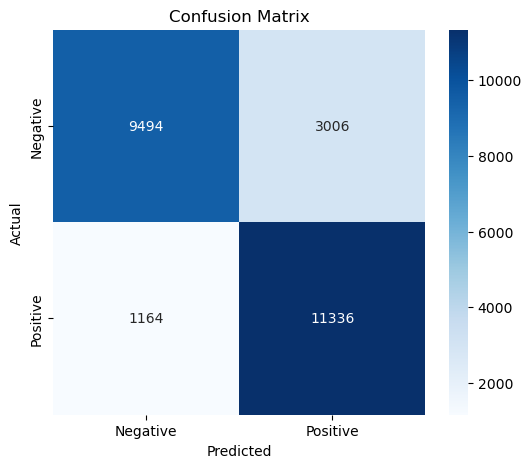


Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.76      0.82     12500
    Positive       0.79      0.91      0.84     12500

    accuracy                           0.83     25000
   macro avg       0.84      0.83      0.83     25000
weighted avg       0.84      0.83      0.83     25000



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================
# Evaluate Model on Test Set
# ==============================
def evaluate_model(model, data_loader):
    model.eval()
    preds, truths = [], []
    device = next(model.parameters()).device
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            pred = torch.argmax(logits, dim=1).cpu().numpy()
            preds.extend(pred)
            truths.extend(y_batch.numpy())
    return np.array(truths), np.array(preds)

# Get predictions on test set
y_true, y_pred = evaluate_model(model, test_loader)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))


## 10) Simple error analysis  inspect misclassified examples

Reviewing misclassified samples helps build intuition about model weaknesses (e.g., sarcasm, negation, long-range dependencies).

In [11]:
# Collect some misclassified examples from the test set (first epoch's predictions)
errors = []
model.eval()
device = next(model.parameters()).device

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        for i in range(X_batch.size(0)):
            true = int(y_batch[i].cpu().numpy())
            pred = int(predicted[i].cpu().numpy())
            if true != pred:
                # retrieve original text (note: the test_loader preserves order)
                # Compute the global index roughly by iterating batches; for simplicity we'll decode from the X ids
                ids = X_batch[i].cpu().numpy().tolist()
                # convert ids back to words (best-effort): build reverse vocab
                rev_vocab = {idx: word for word, idx in vocab.items()}
                words = [rev_vocab.get(idx, '<PAD>') for idx in ids if idx != 0]
                text_snippet = ' '.join(words)[:300]
                errors.append((text_snippet, true, pred))
        if len(errors) >= 5:
            break

for i, (snippet, true, pred) in enumerate(errors[:5], 1):
    print(f"Example {i}:\nSnippet: {snippet}...\nActual: {'Positive' if true==1 else 'Negative'} | Predicted: {'Positive' if pred==1 else 'Negative'}\n{'-'*60}")

Example 1:
Snippet: worth the entertainment value of a rental especially if you like action movies this one features the usual car chases fights with the great van damme kick style shooting battles with the 40 shell load shotgun and even terrorist style bombs all of this is entertaining and competently handled but ther...
Actual: Negative | Predicted: Positive
------------------------------------------------------------
Example 2:
Snippet: first off let me say if you haven t enjoyed a van damme movie since bloodsport you probably will not like this movie most of these movies may not have the best plots or best actors but i enjoy these kinds of movies for what they are this movie is much better than any of the movies the other action g...
Actual: Negative | Predicted: Positive
------------------------------------------------------------
Example 3:
Snippet: i had high hopes for this one until they changed the name to the shepherd border patrol the lamest movie name ever what was wrong wi

## Next steps

You now have a deep-explained RNN-based sentiment classifier. Possible next steps:
- Replace the **RNN** with a more complex architecture like **LSTM**, **BiLSTM**, or **GRU** to compare performance.
- Add more preprocessing (subword tokenization, stemming).
- Experiment with different pooling strategies (last hidden state vs mean).
